# EconML

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pickle
import time
from reed import drop_missing_treatment_or_outcome, Model, transform_outcome

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Parameters

In [2]:
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
load_from_cache=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

configuration_name = 'default'
outcome = 'y_wsce'#'y_wsce'
treatment = 'redufl'
test=True
data_file = "data/all_lasso_selected_20.csv"
inner_cv = 5

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


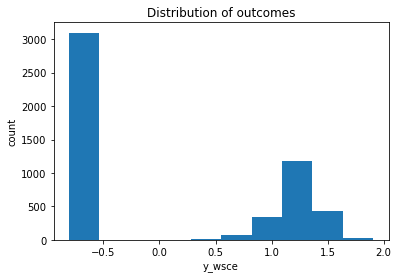

In [3]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Set up models
Specify which models to use and the hyper-parameter space to search over for each

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [4]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 19)
Treated data dimensions: (1368, 19)


### Compute unconditional/unadjusted estimate of treatment effect

In [5]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


## Meta Learners

### TLearner (Separate models for treatment/control response)

In [6]:
from econml.metalearners import TLearner, SLearner, XLearner
from sklearn.model_selection import GridSearchCV

models = GridSearchCV(
    Ridge(), 
    param_grid={
            'alpha':np.logspace(-1,4,30)
    },
    cv = inner_cv
)

inference = None if test else 'bootstrap'

est_t = TLearner(models=models)
est_t.fit(y, t, X=X, inference=inference)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [7]:
if inference is not None:
    display(est_t.ate_inference(X))
else:
    display(est_t.ate(X))

### SLearner (Single model for treatment/control response)

In [8]:
est_s = SLearner(overall_model=models)
est_s.fit(y, t, X=X, inference=inference)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [9]:
if inference is not None:
    display(est_s.ate_inference(X))
else:
    display(est_s.ate(X))

### XLearner

In [10]:
est_x = XLearner(models = models)
est_x.fit(y, t, X=X, inference=inference)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [11]:
if inference is not None:
    display(est_x.ate_inference(X))
else:
    display(est_x.ate(X))

### Doubly Robust

In [12]:
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
n = len(X)
outcome_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_leaf=int(n/100))
pseudo_treatment_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=2, 
                                                  min_samples_leaf=int(n/100))

est_dr = DRLearner(model_regression=outcome_model, model_propensity=propensity_model,
                       model_final=pseudo_treatment_model, cv=5)
# Train DR_learner
est_dr.fit(y, t, X=X, inference=inference)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [13]:
if inference is not None:
    display(est_dr.ate_inference(X))
else:
    display(est_dr.ate(X))